Exercise 63

6.1 Edge attributes on graphs

This exercise is about working with graphs that have edge attributes. We shall use a property related to the interatomic distance, r ij​, as the edge attribute. That will allow the learning to take the physical distance to a neighbor into account and not just the connectivity. This gives a more accurate fit in the end.

6.2 Dataset 

a) Data is given so we load it using the following code:

In [7]:
import numpy as np
import torch
from torch_geometric.data import Data
np.random.seed(0)
torch.manual_seed(0)

data = np.load('dataset_for_exercise_63/pyroxene.npz')

It contains two-dimensional clusters of the mineral pyroxene, which consists of Oxygen, Magnesium and Silicon atoms. These elements have atomic numbers 8, 12, and 14. The following code provides a dictionary to convert the three atomic numbers to either 0, 1, or 2. These consecutive values can then be used to loop up a random respresentation vector for each element stored in one of three rows in embedding_layer:

In [8]:
map_z_to_seq = {8: 0, 12: 1, 14: 2}
num_unique_attributes = len(map_z_to_seq)
embedding_dim = 4
embedding_layer = torch.nn.Embedding(num_unique_attributes, embedding_dim)


Here comes a helper function that will make a torch geometric graph from the i'th data in the datafile:

In [ ]:
def get_graph(index, cutoff=3.5, box_size=10, simple=True):

    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    edge_attr = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])
                if simple==True:
                    edge_attr.append(1) # sets edge attributes to 1
                else:
                    r_ij = D[i,j]
                    print(D[1,1])
                    r_cut = cutoff
                    w_ij = 1/r_ij*(0.5*np.cos(r_ij/r_cut*np.pi)+0.5)
                    edge_attr.append(w_ij)

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32).view(-1, 1)
    z = torch.tensor(data['z_vals'][index],dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    x = embedding_layer(torch.tensor([map_z_to_seq[int(one_z)] for one_z in z])).detach()
    
    return Data(edge_index=edge_index, pos=positions, x=x, y=y, z=z, edge_attr=edge_attr)

6.3 Plotting 

Here is a helpter function to åplot graphs:

In [14]:
import matplotlib.patches as patches

colors = {
8: '#ff0d0d',
12: '#89ff00',
14: '#efc79f'
}
rs = {8: 0.35, 12: 0.8, 14: 0.5}

def plot_graph(ax, graph,  val_min=-1.5, val_max=1.5):
    positions = graph.pos.detach().numpy()

    # Plot the nodes:
    theta = np.linspace(0, 2*np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    for idx, pos in enumerate(positions):
        z = graph.z[idx].item()
        r = rs[z]
        ax.plot(pos[0]+r*x, pos[1]+r*y, c='black')
        ax.fill_between(pos[0]+r*x, pos[1]+r*y, pos[1], color=colors[z])
        if hasattr(graph,'x') and graph.x is not None:
            box_x = pos[0] + 0.3
            box_y = pos[1] + 0.3
            for i, value in enumerate(graph.x[idx]):
                c = min(1,max(0, (value.item() - val_min) / (val_max - val_min)))
                rect = patches.Rectangle(
                    (box_x, box_y - i * 0.25),  # Position
                    0.25, 0.25,  # Width, Height
                    color=str(c),  # Grayscale color
                    ec='black',
                    zorder=10
                )
                ax.add_patch(rect)
    
    # Plot the edges:
    for idx, (edge, attr) in enumerate(zip(graph.edge_index.T, graph.edge_attr)):
        source = positions[edge[0]]
        target = positions[edge[1]]
        linewidth = 3 if attr.item() > 0.1 else 0.5
        ax.plot([source[0], target[0]], [source[1], target[1]], c='black', zorder=0, linewidth=linewidth)

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if graph.y is not None:
        ax.text(0.05,0.05,f'{graph.y.item():.2f}',ha='left',va='bottom',transform=ax.transAxes,backgroundcolor='lightcyan')

b) Use this code to plot the first three graphs:



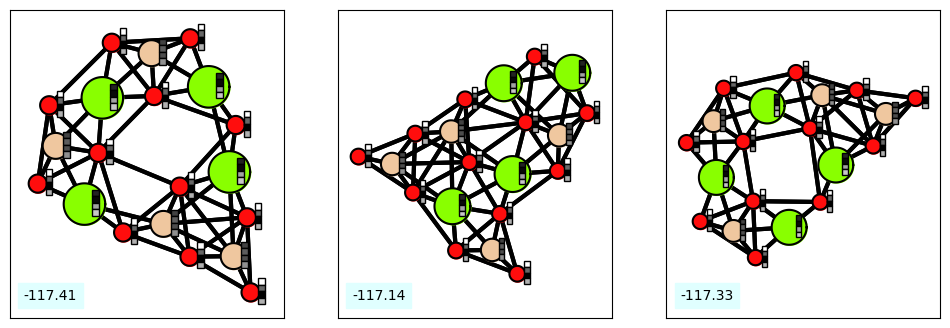

In [15]:
import numpy as np
import matplotlib.pyplot as plt

Ncol = 3
fig, axes = plt.subplots(1, Ncol, figsize=(Ncol*4 ,4))

for i in range(Ncol):
    graph = get_graph(i)
    plot_graph(axes[i], graph)

In your plot, you will not get two different line thicknesses for the edges. That is because so far, the edge attributes have all been set to 1.

6.4 The edge attribute

c) Modify the get_graph function so that it rather than setting all edge attributes to 1, sets them to values according to:

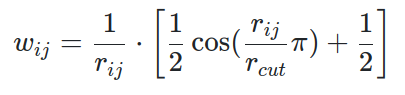

and check that your plot now looks like the above figure.

/tmp/ipykernel_190930/4272736549.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w_ij = 1/r_ij*(0.5*np.cos(r_ij/r_cut*np.pi)+0.5)


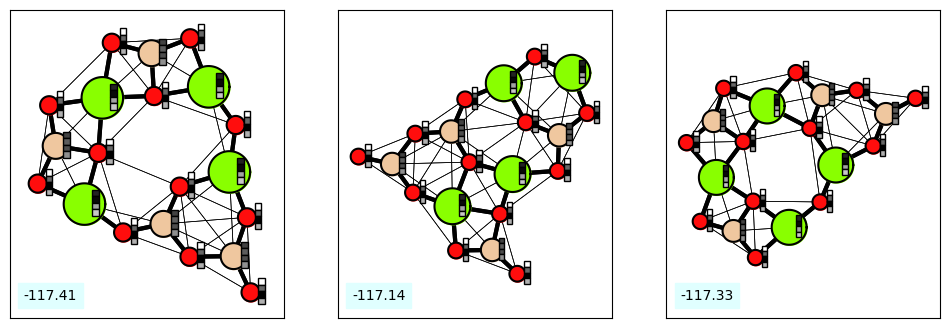

In [ ]:
Ncol = 3
fig, axes = plt.subplots(1, Ncol, figsize=(Ncol*4 ,4))

for i in range(Ncol):
    graph = get_graph(i,3.5,10,False) # calling get_graph with simple=False
    plot_graph(axes[i], graph)

6.5 One GNN layer

Notice in the figures above, how the node attributes are unique to the type of species, but the same irrespective of the environment of the given atom:

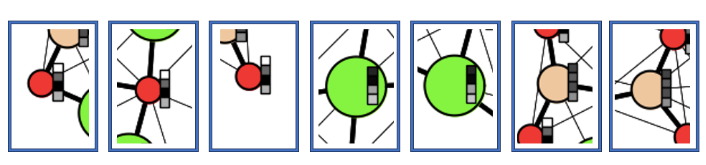

By sending messages in GNN layers that will be modified below.

d) Write a class for a GNN layer that implements:

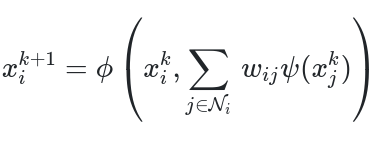

wherew_ij is simply the scalar edge attribute, and where psi(x) is a SiLU-activated R^d -> R^d linear layer for x\in R^d.

Hint: complete this GNN layer:

In [21]:
import torch
from torch.nn import Linear, SiLU
from torch_geometric.nn import MessagePassing

class PhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, d_message=None, aggr='add'):
        super().__init__(aggr=aggr)
        if d_message is None:
            d_message = d_in
        # Define psi as a SiLU-activated linear layer
        self.psi = torch.nn.Sequential(
            Linear(d_in, d_message),
            SiLU()
        )
        # Define phi as a linear layer that aggregates the input and message
        self.phi = Linear(d_in + d_message, d_out)

    def forward(self, x, edge_index, edge_attr):
        # Propagate messages and aggregate them
        aggregated_messages = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        # Concatenate node features with aggregated messages and apply phi
        x = self.phi(torch.cat([x, aggregated_messages], dim=-1))
        return x

    def message(self, x_j, edge_attr):
        # Compute the message as w_ij * psi(x_j)
        return edge_attr.view(-1, 1) * self.psi(x_j)


e) Instantiate the layer and check how the representation changes as the layer is applied to some graphs a number of times.

Hint: Complete this code snippet:



/tmp/ipykernel_190930/4272736549.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w_ij = 1/r_ij*(0.5*np.cos(r_ij/r_cut*np.pi)+0.5)


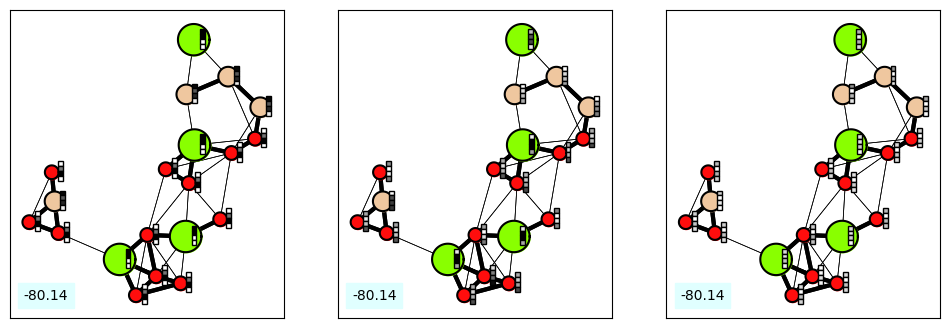

In [28]:
embedding_dim = 4  # Example dimensionality for embeddings
gnn_1 = PhiPsiGNN(embedding_dim, embedding_dim)

graph = get_graph(42,3.5,10,False)
n_col = 3
fig, axes = plt.subplots(1, n_col, figsize=(12, 4))
for ax in axes:
    plot_graph(ax, graph, val_min=-0.75, val_max=0.25) # val_min and val_max determine the colors for the node attributes
    graph.x = gnn_1(graph.x, graph.edge_index, 2 * graph.edge_attr) # 2 is to enhance effect of message

6.6 Model

f) Now set up a model, where GNN layers are used a number of times to make an (learnable) embedding of the atom's representation. Evaluate further a local energy of each atom by passing that representation through fully connected linear layers with activation. Finally, aggregate all the local energies into an energy for the entire cluster.

Hint: Complete this class definition:

In [ ]:
class MyModel(torch.nn.Module):
    def __init__(self, d_hid1=4, d_hid2=4):
        super().__init__()
        self.epochs_trained = 0
        self.mp1 = PhiPsiGNN(embedding_dim, d_hid1, d_message=d_hid1)
        self.mp2 = PhiPsiGNN( YOUR CODE
        self.mp3 = PhiPsiGNN( YOUR CODE
        self.mp4 = PhiPsiGNN(d_hid1, embedding_dim, d_message=d_hid1)
        self.fc1 = torch.nn.Linear(embedding_dim,d_hid2)
        self.fc2 = torch.nn.Linear( YOUR CODE
        self.fc3 = torch.nn.Linear(d_hid2,1)
        self.aggr = SumAggregation()
        
    def forward(self, graph):
        x = self.local_energies(graph)
        x = self.aggr(x, graph.batch)
        return x

    def representation(self, graph):
        x, edge_index, edge_attr = graph.x, graph.edge_index, graph.edge_attr
        x = F.silu(self.mp1(x, edge_index, edge_attr))
        x = YOUR CODE
        x = YOUR CODE
        x = YOUR CODE
        return x
    
    def local_energies(self, graph):
        x = self.representation(graph)
        x = F.silu(self.fc1(x))
        x = YOUR CODE
        x = self.fc3(x)
        return x